In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

## Dataset loading

In [3]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

## Data preprocessing

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Imputation is not required(No nulls)

In [8]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname']) ## As not important for modelling

## Encoding

In [11]:
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])

In [12]:
df["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

#### Imbalanced dataset

In [13]:
corr_matrix = df.corr()

target_corr = corr_matrix['Exited'].sort_values(key=lambda x: abs(x), ascending=False)

print(target_corr)

Exited             1.000000
Age                0.285323
IsActiveMember    -0.156128
Balance            0.118533
Gender            -0.106512
NumOfProducts     -0.047820
Geography          0.035943
CreditScore       -0.027094
Tenure            -0.014001
EstimatedSalary    0.012097
HasCrCard         -0.007138
Name: Exited, dtype: float64


### Train test split

In [15]:
df_input = df
df_input = df_input.drop("Exited", axis=1)
X= df_input
y= df["Exited"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Training different Models

In [24]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [25]:
results=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class (fraud)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None  # ROC AUC won't be used
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3    Gradient Boosting    0.8675   0.788618  0.476658  0.594181  0.867261
5             CatBoost    0.8680   0.801688  0.466830  0.590062  0.858009
2        Random Forest    0.8590   0.775330  0.432432  0.555205  0.848369
4              XGBoost    0.8470   0.683636  0.461916  0.551320  0.830524
1        Decision Tree    0.7910   0.485564  0.454545  0.469543  0.665754
0  Logistic Regression    0.6485   0.325882  0.680590  0.440732  0.706536


In [26]:
print(confusion_matrix(y_test, y_pred))

[[1546   47]
 [ 217  190]]


### Hyperparameter tuning

In [27]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)

# Evaluate Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

ROC AUC: 0.7220078321773237


### Precision Recall curve

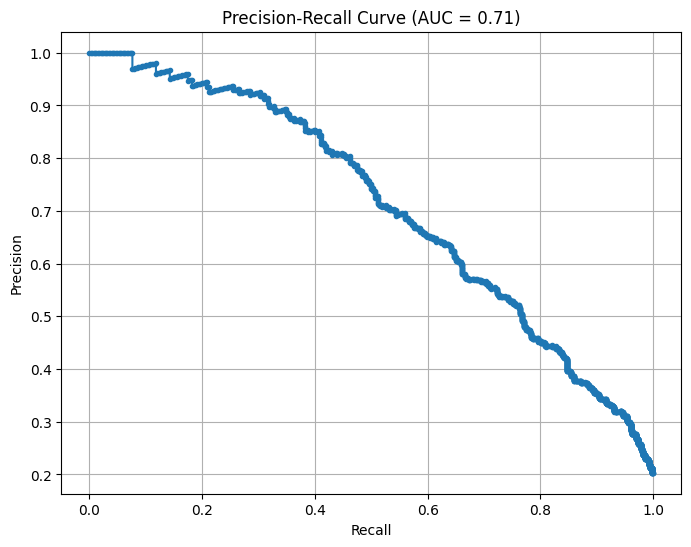

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

### With different thresholds

In [29]:
y_scores = best_model.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.4, 0.5]
for thresh in thresholds:
    y_thresh = (y_scores >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_thresh))
    print(confusion_matrix(y_test, y_thresh))


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1593
           1       0.63      0.64      0.64       407

    accuracy                           0.85      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000

[[1437  156]
 [ 145  262]]

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.70      0.55      0.61       407

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000

[[1497   96]
 [ 184  223]]

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83   

### Threshold 0.3 works well with Gradient Boosting as the final model